In [92]:
%load_ext autoreload
%autoreload 2
from scipy.stats import poisson
from utils import *
import math
from IPython.display import display, HTML
ins = BrainSpan()
mpl.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
#print bp_exon_col_meta.shape
#display(bp_exon_col_meta.head(2)) 
#print "Sample size", pd.unique(bp_exon_col_meta.donor_id).size
#print "Periods:",bp_exon_col_meta.drop_duplicates("donor_id").groupby("Period")["Period"].count()
strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)
# Rows Meta Data
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
#display(bp_exon_row_meta.head(2))
#display(ExonExp.head(2))

In [60]:
def loaddict():
    res = {}
    fin = open("/Users/jiayao/Work/BrainDisorders/src/cds.dict", 'rb')
    for l in fin:
        llist = l.strip().split()
        gene, exon_s, cds_s, cds_e = llist[0], int(llist[1])-1, int(llist[2])-1, int(llist[3])
        if gene not in res:
            res[gene] = {}
        if exon_s not in res[gene]:
            res[gene][exon_s] = (cds_s, cds_e)
    return res
cds_dict = loaddict()
def addcds(row, cds_dict):
    s = row["start"]
    gene = row["gene_symbol"]
    if gene not in cds_dict:
        return row["exon length"]
    if s in cds_dict[gene]:
        cds_s, cds_e = cds_dict[gene][s]
        return cds_e - cds_s
    else:
        return row["exon length"]

In [61]:
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta.head(5)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,66
2,3,1086864,ENSG00000000003,TSPAN6,7105.0,99887481,99887565,84,84
3,4,1086864,ENSG00000000003,TSPAN6,7105.0,99888401,99888536,135,135
4,5,1086864,ENSG00000000003,TSPAN6,7105.0,99888927,99889026,99,99


In [62]:
ins = BrainSpan()

In [63]:
def load_mutation_exp(VarFile, expdictfile, outname="tmp.targeted.exons.xlsx", row_meta=bp_exon_row_meta):
    row_meta = ins.AssignVar2Exon5(row_meta, VarFile, IntersectionWithPredicted=False)
    row_meta_with_gene = row_meta[row_meta["GeneHited"]=="T"]
    row_meta_with_gene.to_excel(outname, index=False)
    print "Num.of.Genes:", row_meta_with_gene.groupby('gene_symbol').count().shape

    expdict = ins.LoadGeneSetDataFromFil(expdictfile)
    Genes = list(set(row_meta_with_gene["gene_symbol"].values))
    gene_exon_set = GeneExonSet(expdict)
    for i, gene in enumerate(Genes):
        gene_df = row_meta_with_gene[row_meta_with_gene["gene_symbol"]==gene]
        TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
        UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
        TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
        UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
        gene_exon_set.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
    print len(gene_exon_set.genes), len(gene_exon_set.TargetedExon),len(gene_exon_set.UntargetedExon)
    return gene_exon_set

#[("proband LGD", 'red', prolgd), ("gnomAD LGD", 'blue', gnomADlgd),
# ("gnomAD male LGD", 'yellow', gnomADlgd_male),("gnomAD female LGD", 'green', gnomADlgd_female) ]

def plot_mutation_exp(title, datasets, ylims=((4,12.25))):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
    plt.title(title)
    for i, (title, color, Dat) in enumerate(datasets):
        Tseq, Terr, Useq, Uerr, All, Allerr = Dat
        ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
        #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color=color)
        ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)

    ax.grid(True)
    ax.axvline(x=7.5, color="grey", linestyle="--")
    plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper right', fontsize=8)
    plt.xlabel("Dev Stages")
    plt.ylabel("Expression")
    plt.ylim(ylims)
    plt.show()

In [64]:
# gnomAD variants in wigler gene sets
VarFile = pd.read_csv("../data/benign.all.tsv", delimiter="\t")
expdictfile = "data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv"
MaleFile = VarFile[(VarFile["AC_Male"]!=0) & (VarFile["AC_Female"]==0)]
FemaleFile = VarFile[(VarFile["AC_Female"]!=0) & (VarFile["AC_Male"]==0)]
gnomADLGD = load_mutation_exp(VarFile, expdictfile, outname="GenesExons.LGD_gnomAD_predicted.xlsx")
M_gnomADLGD = load_mutation_exp(MaleFile, expdictfile, outname="GenesExons.LGD_gnomAD_predicted.M.xlsx")
F_gnomADLGD = load_mutation_exp(FemaleFile, expdictfile, outname="GenesExons.LGD_gnomAD_predicted.F.xlsx")

309222Num.of.Genes: (101, 12)
101 464 1901
309222Num.of.Genes: (89, 12)
89 269 1897
309222Num.of.Genes: (85, 12)
85 226 1801


In [65]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape

Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)

(94, 15)
94 118 2151


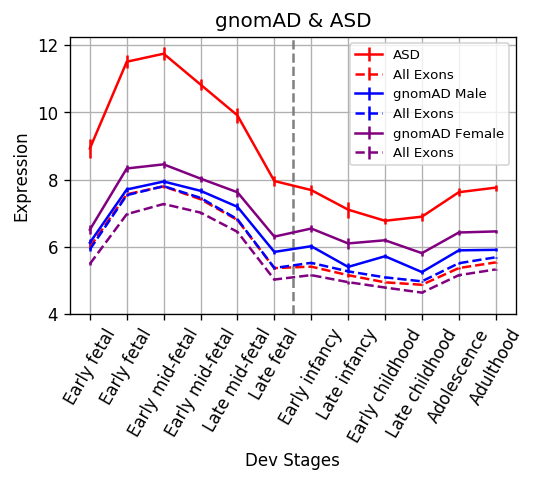

In [66]:
ssclgd = ProbandLGD.Reduce(logscale=False)
gnomADlgd_male = M_gnomADLGD.Reduce(logscale=False)
gnomADlgd_female = F_gnomADLGD.Reduce(logscale=False)
datasets=[("ASD","red",ssclgd), ("gnomAD Male","blue",gnomADlgd_male), ("gnomAD Female","purple",gnomADlgd_female)]
plot_mutation_exp("gnomAD & ASD", datasets, ylims=((4,12.25)))

309222Num.of.Genes: (82, 12)
82 205 1777


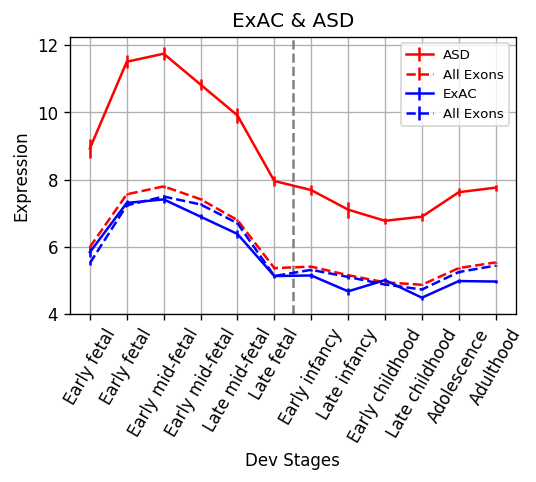

In [67]:
# gnomAD variants in wigler gene sets
VarFile = pd.read_csv("../data/benign.nonssych.tsv", delimiter="\t")
expdictfile = "data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv"
ExAC_nonSYCH_LGD = load_mutation_exp(VarFile, expdictfile, outname="GenesExons.LGD_ExAC.nonSYCH_predicted.xlsx")
ssclgd = ProbandLGD.Reduce(logscale=False)
exaclgd = ExAC_nonSYCH_LGD.Reduce(logscale=False)
datasets=[("ASD","red",ssclgd), ("ExAC","blue",exaclgd)]
plot_mutation_exp("ExAC & ASD", datasets, ylims=((4,12.25)))

In [41]:
VarFile = pd.read_csv("../data/DenovoVariants/denovodb.schizophrenia.dedup.tsv", delimiter="\t")
expdictfile = "data/qn.SCZ.Regionsgt20.GeneExonLog2Exp.csv"
SCZ_All = load_mutation_exp(VarFile, expdictfile, outname="GenesExonsTargetedBy_SCZ.xlsx")
scz_genes = [x.strip() for x in file("/Users/jiayao/Work/BrainDisorders/data/scz-predicted-wiglerlike.genesymbol.txt")]
VarFile_SC2_Predicted = VarFile[VarFile["Gene"].isin(scz_genes)]
SCZ_Predicted = load_mutation_exp(VarFile_SC2_Predicted, expdictfile, outname="GenesExonsTargetedBy_SCZ_predicted.xlsx")

309222Num.of.Genes: (553, 12)
553 575 11644
309222Num.of.Genes: (52, 12)
52 55 950


In [44]:
Var_SCZ_LGD = VarFile[VarFile["FunctionClass"]!="missense"]
SCZ_LGD = load_mutation_exp(Var_SCZ_LGD, expdictfile, outname="GenesExonsTargetedBy_SCZ_LGD.xlsx")

309222Num.of.Genes: (90, 12)
90 91 1903


In [147]:
Var_scz_pre_lgd = Var_SCZ_LGD[Var_SCZ_LGD["Gene"].isin(scz_genes)]
expdictfile = "data/qn.SCZ.Regionsgt20.GeneExonLog2Exp.csv"
SCZ_LGD_Pre = load_mutation_exp(Var_scz_pre_lgd, expdictfile, outname="GenesExonsTargetedBy_SCZ_LGD.xlsx")               

309222Num.of.Genes: (11, 12)
11 12 152


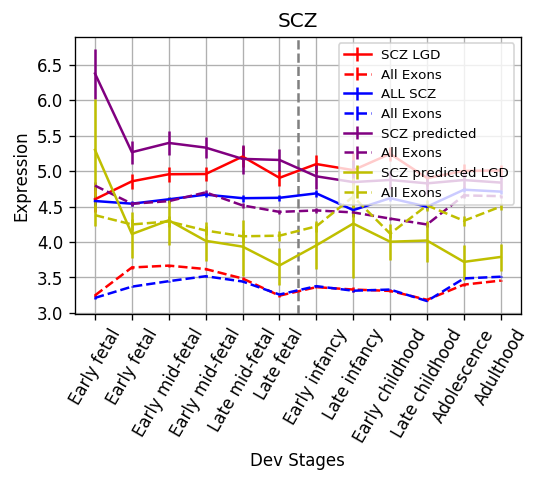

In [148]:
ssclgd = ProbandLGD.Reduce(logscale=False)
scz = SCZ_All.Reduce(logscale=False)
scz_pre = SCZ_Predicted.Reduce(logscale=False)
scz_lgd = SCZ_LGD.Reduce(logscale=False)
scz_pre_lgd = SCZ_LGD_Pre.Reduce(logscale=False)
datasets=[("SCZ LGD","red",scz_lgd), ("ALL SCZ","blue",scz), ("SCZ predicted","purple",scz_pre), ("SCZ predicted LGD","y",scz_pre_lgd)]
#datasets=[("SCZ","blue",scz), ("SCZ predicted","purple",scz_pre)]
plot_mutation_exp("SCZ", datasets, ylims=None )

In [79]:
VarFile = "../data/DenovoVariants/clinvar.predicted.path.lgd.tsv"
bp_exon_row_meta_scz = ins.AssignVar2Exon4(bp_exon_row_meta, VarFile, IntersectionWithPredicted=False)

bp_exon_row_meta_with_gene_scz = bp_exon_row_meta_scz[bp_exon_row_meta_scz["GeneHited"]=="T"]
bp_exon_row_meta_with_gene_scz.to_excel("GenesExonsTargetedByLGD_clinver_predicted.xlsx", index=False)
print bp_exon_row_meta_with_gene_scz.groupby('gene_symbol').count().shape
bp_exon_row_meta_with_var_scz = bp_exon_row_meta_with_gene_scz[bp_exon_row_meta_with_gene_scz["Vars"]!=""]
bp_exon_row_meta_without_var_scz = bp_exon_row_meta_with_gene_scz[bp_exon_row_meta_with_gene_scz["Vars"]==""]
print bp_exon_row_meta_with_gene_scz.shape, bp_exon_row_meta_with_var_scz.shape, bp_exon_row_meta_without_var_scz.shape

309222(40, 12)
(940, 13) (252, 13) (688, 13)


In [80]:
Genes = list(set(bp_exon_row_meta_with_gene_scz["gene_symbol"].values))
#Genes = set(Genes).intersection(set(scz_genes))
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
#expdict = ins.LoadGeneSetDataFromFil("data/qn.SCZ.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
SCZLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene_scz[bp_exon_row_meta_with_gene_scz["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SCZLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(SCZLGD.genes), len(SCZLGD.TargetedExon),len(SCZLGD.UntargetedExon)

40 252 688


In [81]:
print SCZLGD.genes

['CIC', 'SRCAP', 'FOXP1', 'ADNP', 'GIGYF2', 'L1CAM', 'BCL11A', 'TBR1', 'ZFHX3', 'CTNNB1', 'ZMYND11', 'DSCAM', 'ANKRD11', 'GRIN2B', 'CHD2', 'CHD8', 'AHDC1', 'RAI1', 'SCN2A', 'CNOT3', 'CUL3', 'ASH1L', 'PHF21A', 'WAC', 'IRF2BPL', 'SYNGAP1', 'DYRK1A', 'SUFU', 'TRIP12', 'SHANK2', 'NFIB', 'NFIA', 'SPAST', 'MED13L', 'ARID1B', 'NOTCH1', 'NRXN1', 'POGZ', 'MBD5', 'KAT6A']


In [83]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape

#Genes = list( set(bp_exon_row_meta_with_gene["gene_symbol"].values).difference(genes) )
Genes = SCZLGD.genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)

(94, 15)
40 56 884


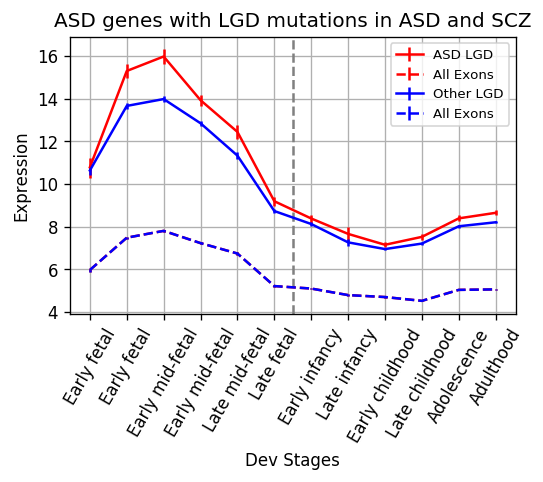

In [84]:
sczlgd = SCZLGD.Reduce(logscale=False)
prolgd = ProbandLGD.Reduce(logscale=False)

fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in ASD and SCZ")
for i, (title, color, Dat) in enumerate([("ASD LGD", 'red', prolgd), ("Other LGD", 'blue', sczlgd)
                                       ]):
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label="Untargeted Exons", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)

ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.ylim(4,12.25)
plt.show()
#plt.savefig("./figures/ProbandLGD.pdf", bbox_inches = "tight")

In [85]:
VarFile = "../data/DenovoVariants/denovo-db.non-autism.predicted.genes.lgd.tsv"
#VarFile = "../data/DenovoVariants/denovo-db.ID.predicted.genes.lgd.tsv"
bp_exon_row_meta_scz = ins.AssignVar2Exon4(bp_exon_row_meta, VarFile, IntersectionWithPredicted=False)

bp_exon_row_meta_with_gene_scz = bp_exon_row_meta_scz[bp_exon_row_meta_scz["GeneHited"]=="T"]
bp_exon_row_meta_with_gene_scz.to_excel("GenesExonsTargetedByLGD_non_autism_predicted.xlsx", index=False)
print bp_exon_row_meta_with_gene_scz.groupby('gene_symbol').count().shape
bp_exon_row_meta_with_var_scz = bp_exon_row_meta_with_gene_scz[bp_exon_row_meta_with_gene_scz["Vars"]!=""]
bp_exon_row_meta_without_var_scz = bp_exon_row_meta_with_gene_scz[bp_exon_row_meta_with_gene_scz["Vars"]==""]
print bp_exon_row_meta_with_gene_scz.shape, bp_exon_row_meta_with_var_scz.shape, bp_exon_row_meta_without_var_scz.shape

309222(45, 12)
(1162, 13) (134, 13) (1028, 13)


In [86]:
Genes = list(set(bp_exon_row_meta_with_gene_scz["gene_symbol"].values))
#Genes = set(Genes).intersection(set(scz_genes))
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
#expdict = ins.LoadGeneSetDataFromFil("data/qn.SCZ.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
SCZLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene_scz[bp_exon_row_meta_with_gene_scz["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SCZLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(SCZLGD.genes), len(SCZLGD.TargetedExon),len(SCZLGD.UntargetedExon)

45 134 1028


In [88]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape

#Genes = list( set(bp_exon_row_meta_with_gene["gene_symbol"].values).difference(genes) )
Genes = SCZLGD.genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)

(94, 15)
45 64 1098


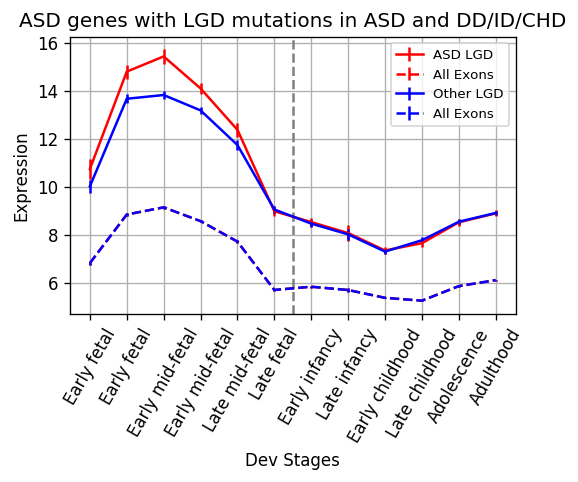

In [137]:
sczlgd = SCZLGD.Reduce(logscale=False)
prolgd = ProbandLGD.Reduce(logscale=False)

fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in ASD and DD/ID/CHD")
for i, (title, color, Dat) in enumerate([("ASD LGD", 'red', prolgd), ("Other LGD", 'blue', sczlgd)
                                       ]):
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label="Untargeted Exons", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)

ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.ylim(4,12.25)
plt.show()
#plt.savefig("./figures/ProbandLGD.pdf", bbox_inches = "tight")

In [151]:
# gnomAD variants in wigler gene sets
VarFile = pd.read_csv("../data/DenovoVariants/denovo-db.non-autism.predicted.genes.lgd.tsv", delimiter="\t")
expdictfile = "data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv"
IDFile = VarFile[(VarFile["PrimaryPhenotype"]=="intellectualDisability") ]
DDFile = VarFile[(VarFile["PrimaryPhenotype"]=="developmentalDisorder") ]
CHDFile = VarFile[(VarFile["PrimaryPhenotype"]=="congenital_heart_disease") ]
IDLGD = load_mutation_exp(IDFile, expdictfile, outname="GenesExons.LGD_ID_predicted.xlsx")
DDLGD = load_mutation_exp(DDFile, expdictfile, outname="GenesExons.LGD_DD_predicted.M.xlsx")
CHDLGD = load_mutation_exp(CHDFile, expdictfile, outname="GenesExons.LGD_CHD_predicted.F.xlsx")

309222Num.of.Genes: (24, 12)
24 43 604
309222Num.of.Genes: (31, 12)
31 80 671
309222Num.of.Genes: (11, 12)
11 12 286


(94, 15)
24 39 608


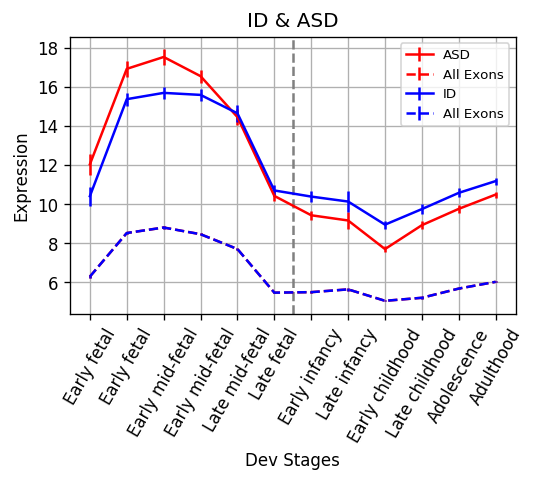

In [160]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape

#Genes = list( set(bp_exon_row_meta_with_gene["gene_symbol"].values).difference(genes) )
Genes = IDLGD.genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)
A = IDLGD.Reduce(logscale=False)
B = ProbandLGD.Reduce(logscale=False)
datasets=[("ASD","red",B), ("ID","blue",A)]
plot_mutation_exp("ID & ASD", datasets, ylims=None)

31 43 708


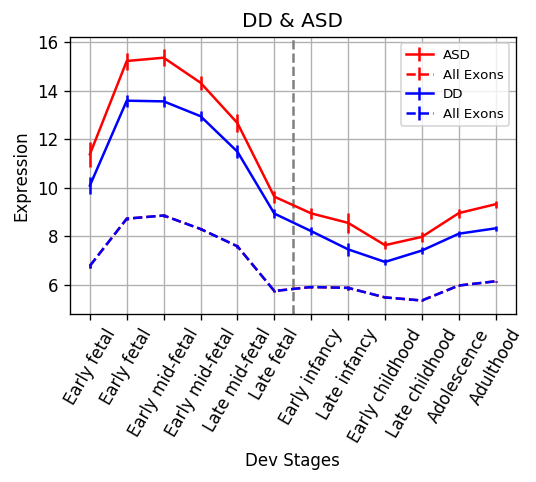

In [159]:
Genes = DDLGD.genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)
A = DDLGD.Reduce(logscale=False)
B = ProbandLGD.Reduce(logscale=False)
datasets=[("ASD","red",B), ("DD","blue",A)]
plot_mutation_exp("DD & ASD", datasets, ylims=None)

11 14 284


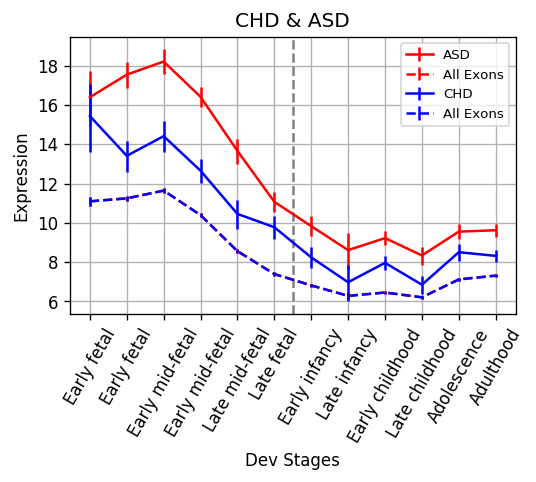

In [158]:
Genes = CHDLGD.genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)
A = CHDLGD.Reduce(logscale=False)
B = ProbandLGD.Reduce(logscale=False)
datasets=[("ASD","red",B), ("CHD","blue",A)]
plot_mutation_exp("CHD & ASD", datasets, ylims=None)

In [133]:
# Test diff
scz_pre, scz_post, asd_pre, asd_post = CollectDat(SCZLGD, ProbandLGD)
print np.mean(scz_pre),np.mean(scz_post),np.mean(asd_pre),np.mean(asd_post)
print scipy.stats.mannwhitneyu(scz_pre, asd_pre, alternative="two-sided")
print scipy.stats.mannwhitneyu(scz_post, asd_post, alternative="two-sided")
print scipy.stats.ttest_ind(scz_pre, asd_pre)
print scipy.stats.ttest_ind(scz_post, asd_post)

3.60268398334 3.04553188941 3.69324789462 3.04422924978
MannwhitneyuResult(statistic=182163117.0, pvalue=3.3753043732265155e-14)
MannwhitneyuResult(statistic=345958201.0, pvalue=7.5415912755081134e-05)
Ttest_indResult(statistic=-5.7328545686895822, pvalue=9.9432989158887659e-09)
Ttest_indResult(statistic=0.093405911425126345, pvalue=0.92558142371973795)


In [127]:
print len(scz_pre), len(scz_post), len(asd_pre), len(asd_post)

28274 38458 13504 18368


In [408]:
print ProbandLGD.TargetedExon
#print SCZLGD.TargetedExon
print len(set(ProbandLGD.TargetedExon).intersection(set(SCZLGD.TargetedExon)))
print len(set(ProbandLGD.TargetedExon).difference(set(SCZLGD.TargetedExon)))

[26742, 34566, 41150, 75103, 105018, 105020, 115772, 170985, 66473, 66477, 39026, 5921, 67436, 169336, 120872, 1265, 40582, 40586, 40587, 40598, 40600, 196496, 182178, 224368, 85141, 55719, 105007, 105008, 14590, 14616, 95076, 95079, 31164, 48345, 8760, 70038, 54568, 101670, 35982, 35985, 74592, 177795, 217956, 145371, 145377, 145379, 183587, 183603, 138898, 129477, 132778, 132781, 132787, 79519, 79524, 11546, 11552, 130261, 16220, 125152, 125156, 125168, 229275, 28311]
20
44


In [397]:
Both_genes = SCZLGD.genes

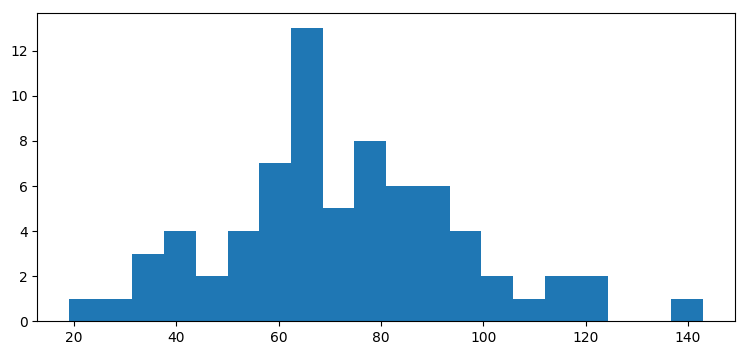

In [405]:
Dir = "/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/"
Predicted = set([x.strip() for x in file(Dir+"../ASD_high_confidence_genes_post80.txt")])
LGD = set(["noStart", "frame-shift", "nonsense", "noEnd", "no-frame-shift-newStop","splice-site"])
InPro = set(["pMsM", "pMsF", "pFsF", "pF", "pM", "pFsM"])
phenotype = pd.read_excel(Dir+"Supplementary_Table_1.xlsx")
variants = pd.read_excel(Dir+"Supplementary_Table_2.xlsx")
ProLGD = variants[(variants["inChild"].isin(InPro)) & (variants["effectType"].isin(LGD))]
ID = ProLGD[(ProLGD["effectGene"].isin(Both_genes))]
#Female = ProLGD[(ProLGD["inChild"] == "pF") & (ProLGD["effectGene"].isin(Both_genes))]
#Male = ProLGD[(ProLGD["inChild"] == "pM") & (ProLGD["effectGene"].isin(Both_genes))]

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
fig, ax1 = plt.subplots(figsize=(9, 4))
IDIQ = phenotype[phenotype["familyId"].isin(ID["familyId"].values)]['probandNVIQ']
#plt.violinplot([IDIQ])
plt.hist(IDIQ, bins=20)
#set_axis_style(ax1, ["M", "F", "M HC LGD", "F HC LGD", "Ma LGD", "F LGD"])
#plt.grid(True)
plt.show()
#print len(MaleIQ), len(FemaleIQ)
#print scipy.stats.mannwhitneyu(MaleIQ, FemaleIQ, alternative="two-sided")

[10.750200221380304, 14.800662711854859, 15.432273752138546, 14.101501381402818, 12.381205199810912, 8.9976324760601347, 8.5446802711342098, 8.0876599906183912, 7.3635364751216512, 7.667566994844, 8.5356718183320517, 8.9071743554675944] [6.6592948497482647, 8.5979142940673814, 8.8831698972177264, 8.33920168996341, 7.5234482017097157, 5.573839315674606, 5.7289426692283305, 5.6052613216016889, 5.2978698311347721, 5.1625322835307852, 5.7553014252836023, 5.9985462921787613]
proband LGD
avg.pre.tar: 12.7439126238; avg.post.tar: 8.18438165092; ratio.tar:1.55710146072
avg.pre.untar: 7.59614470806; avg.post.untar: 5.59140897049; ratio.untar:1.35853856303
rate.ratio:1.14615919128
[4.6878605458099152, 5.8597974809699664, 5.962173670976143, 5.5687591148018054, 5.4102558803962451, 4.1513798965078488, 4.5351089776187612, 4.1301653596749821, 4.1631956773255814, 3.7626672784492641, 4.0987597567836351, 4.1495486083578008] [3.7326132587915697, 4.6452100063432189, 4.981850532459827, 5.1977381145579669, 

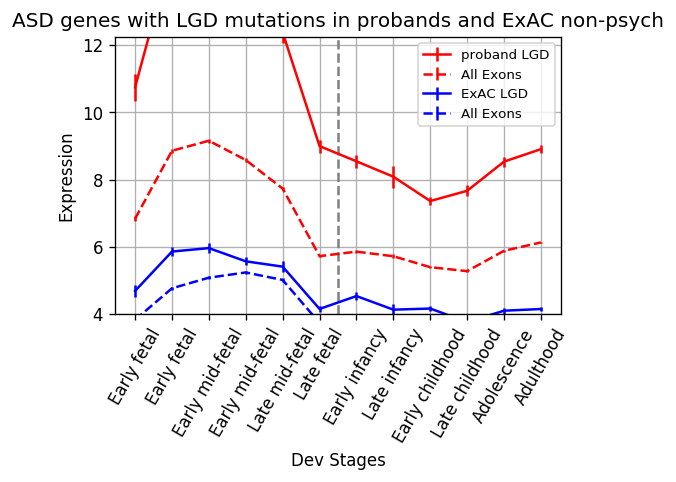

In [399]:
gnomADlgd = ExACLGD.Reduce(logscale=False)
prolgd = ProbandLGD.Reduce(logscale=False)

fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands and ExAC non-psych")
PRE = [None, None]
POST = [None, None]
for i, (title, color, Dat) in enumerate([("proband LGD", 'red', prolgd), ("ExAC LGD", 'blue', gnomADlgd)
                                       ]):
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)
    #pre, post, bias = Bias(Tseq, Useq)
    #print title, pre, post, bias
    print Tseq, Useq
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    if i == 0:
        PRE[0] = pre1
        POST[0] = post1
    elif i == 1:
        PRE[1] = pre1
        POST[1] = post1
    print title
    print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(pre1, post1, T)
    print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(pre2, post2, U)
    print "rate.ratio:{}".format(T/U)
print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(PRE[0], POST[0], PRE[0]/POST[0])
print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(PRE[1], POST[1], PRE[1]/POST[1])
print "rate.ratio:{}".format((PRE[0]/POST[0])/(PRE[1]/POST[1]))
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.ylim(4,12.25)
plt.show()
#plt.savefig("./figures/ProbandLGD.pdf", bbox_inches = "tight")

In [84]:
gnomADlgd = set(ExACLGD.TargetedExon)
prolgd = set(ProbandLGD.TargetedExon)
print gnomADlgd.intersection(prolgd), len(gnomADlgd.intersection(prolgd))

set([40587, 35982, 85141, 178074, 11552, 95393, 55719, 78000, 183603, 115772, 41150, 168790, 40535, 117593, 173658, 16220, 53213, 74592, 193774, 125168, 1265, 39026, 169336]) 23


In [85]:
interect = set([40587, 35982, 85141, 145688, 178074, 11552, 95393, 55719, 78000, 183603, 132787, 115772, 41150, 211016, 168790, 40535, 117593, 173658, 16220, 53213, 74592, 193774, 125168, 1265, 39026, 169336])

In [93]:
bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(interect)]
genes = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(interect)]["gene_symbol"].values

In [107]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape

Genes = genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
Genes = genes
ProbandLGD2 = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD2.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD2.genes), len(ProbandLGD2.TargetedExon),len(ProbandLGD2.UntargetedExon)

(94, 15)
26 38 509


In [97]:
bp_exon_row_meta_with_gene_ExACLGD = pd.read_excel("GenesExonsTargetedByLGD_ExAC_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene_ExACLGD = bp_exon_row_meta_with_gene_ExACLGD.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene_ExACLGD.groupby('gene_symbol').count().shape

#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
Genes = genes
ExACLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene_ExACLGD[bp_exon_row_meta_with_gene_ExACLGD["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ExACLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ExACLGD.genes), len(ExACLGD.TargetedExon),len(ExACLGD.UntargetedExon)

(69, 12)
26 59 475


proband LGD
avg.pre.tar: 7.72667826403; avg.post.tar: 6.31777976694; ratio.tar:1.22300531976
avg.pre.untar: 4.40782357602; avg.post.untar: 3.60258356158; ratio.untar:1.22351737321
rate.ratio:0.999581490661
ExAC LGD
avg.pre.tar: 5.27337109824; avg.post.tar: 4.1399076097; ratio.tar:1.27378956136
avg.pre.untar: 4.53470659922; avg.post.untar: 3.71929288401; ratio.untar:1.21923890929
rate.ratio:1.04474156103
avg.pre.tar: 7.72667826403; avg.post.tar: 6.31777976694; ratio.tar:1.22300531976
avg.pre.untar: 5.27337109824; avg.post.untar: 4.1399076097; ratio.untar:1.27378956136
rate.ratio:0.960131372446


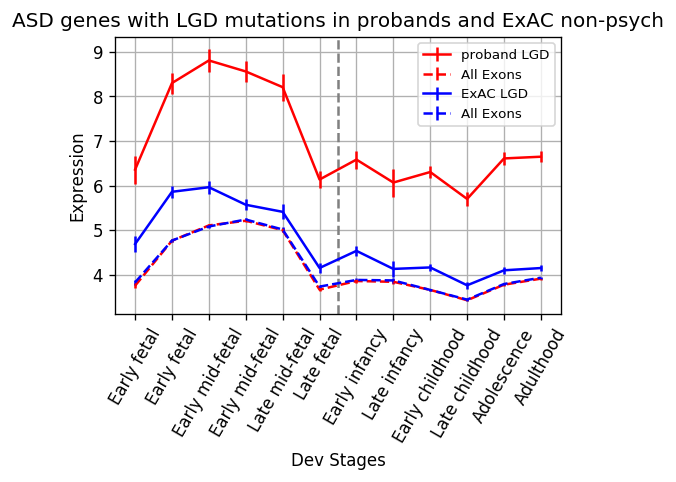

In [101]:
gnomADlgd = ExACLGD.Reduce(logscale=False)
prolgd = ProbandLGD.Reduce(logscale=False)

fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands and ExAC non-psych")
PRE = [None, None]
POST = [None, None]
for i, (title, color, Dat) in enumerate([("proband LGD", 'red', prolgd), ("ExAC LGD", 'blue', gnomADlgd)
                                       ]):
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)
    #pre, post, bias = Bias(Tseq, Useq)
    #print title, pre, post, bias
    pre1 = np.mean(Tseq[0:6])
    #pre1 = max(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    #pre2 = max(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    if i == 0:
        PRE[0] = pre1
        POST[0] = post1
    elif i == 1:
        PRE[1] = pre1
        POST[1] = post1
    print title
    print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(pre1, post1, T)
    print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(pre2, post2, U)
    print "rate.ratio:{}".format(T/U)
print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(PRE[0], POST[0], PRE[0]/POST[0])
print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(PRE[1], POST[1], PRE[1]/POST[1])
print "rate.ratio:{}".format((PRE[0]/POST[0])/(PRE[1]/POST[1]))
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.ylim(4,12.25)
plt.show()
#plt.savefig("./figures/ProbandLGD.pdf", bbox_inches = "tight")

In [289]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape

Genes = list( set(bp_exon_row_meta_with_gene["gene_symbol"].values).difference(genes) )
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)

(94, 15)
94 118 2151


In [110]:
bp_exon_row_meta_with_gene_ExACLGD = pd.read_excel("GenesExonsTargetedByLGD_ExAC_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene_ExACLGD = bp_exon_row_meta_with_gene_ExACLGD.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene_ExACLGD.groupby('gene_symbol').count().shape

#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
Genes = Genes
ExACLGD2 = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene_ExACLGD[bp_exon_row_meta_with_gene_ExACLGD["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ExACLGD2.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ExACLGD2.genes), len(ExACLGD2.TargetedExon),len(ExACLGD2.UntargetedExon)

(69, 12)
68 107 1148


proband LGD
avg.pre.tar: 11.5601307002; avg.post.tar: 7.83687205809; ratio.tar:1.47509498873
avg.pre.untar: 7.5980105121; avg.post.untar: 5.70807510484; ratio.untar:1.33109855294
rate.ratio:1.10817864348
proband LGD
avg.pre.tar: 7.72667826403; avg.post.tar: 6.31777976694; ratio.tar:1.22300531976
avg.pre.untar: 4.40782357602; avg.post.untar: 3.60258356158; ratio.untar:1.22351737321
rate.ratio:0.999581490661
ExAC LGD
avg.pre.tar: 7.69346851616; avg.post.tar: 5.52983504254; ratio.tar:1.39126546398
avg.pre.untar: 7.38352367352; avg.post.untar: 5.79242849681; ratio.untar:1.27468533752
rate.ratio:1.09145796458
avg.pre.tar: 11.5601307002; avg.post.tar: 7.83687205809; ratio.tar:1.47509498873
avg.pre.untar: 7.72667826403; avg.post.untar: 6.31777976694; ratio.untar:1.22300531976
rate.ratio:1.20612311729


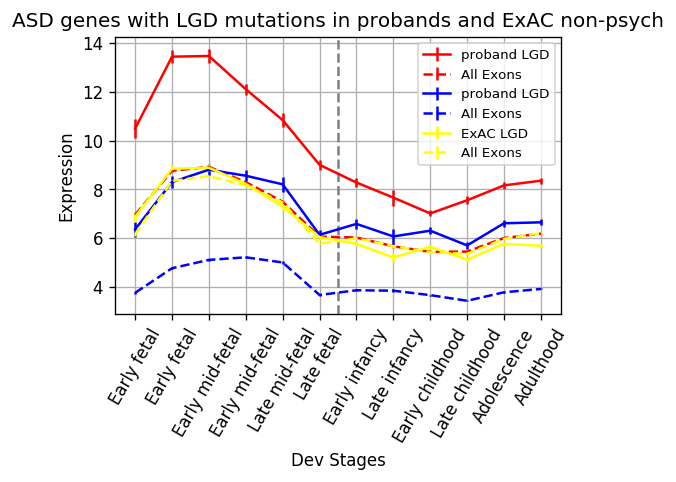

In [114]:
gnomADlgd = ProbandLGD2.Reduce(logscale=False)
prolgd = ProbandLGD.Reduce(logscale=False)
exac = ExACLGD2.Reduce(logscale=False)

fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands and ExAC non-psych")
PRE = [None, None]
POST = [None, None]
for i, (title, color, Dat) in enumerate([("proband LGD", 'red', prolgd), ("proband LGD", 'blue', gnomADlgd),
                     ("ExAC LGD", 'yellow', exac)                  ]):
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)
    #pre, post, bias = Bias(Tseq, Useq)
    #print title, pre, post, bias
    pre1 = np.mean(Tseq[0:6])
    #pre1 = max(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    #pre2 = max(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    if i == 0:
        PRE[0] = pre1
        POST[0] = post1
    elif i == 1:
        PRE[1] = pre1
        POST[1] = post1
    print title
    print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(pre1, post1, T)
    print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(pre2, post2, U)
    print "rate.ratio:{}".format(T/U)
print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(PRE[0], POST[0], PRE[0]/POST[0])
print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(PRE[1], POST[1], PRE[1]/POST[1])
print "rate.ratio:{}".format((PRE[0]/POST[0])/(PRE[1]/POST[1]))
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.ylim(4,12.25)
plt.show()
#plt.savefig("./figures/ProbandLGD.pdf", bbox_inches = "tight")

[1.0909680535940556, 1.0917326869411395, 1.0922499189830506, 1.0933642872134894, 1.0937257452446609, 1.0971073183726188, 1.0996974927050414, 1.0999988839948651, 1.1034537936221369, 1.1118174166872572]
999
1
0.001


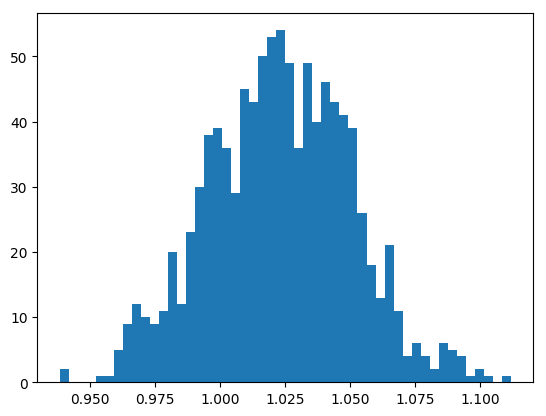

In [117]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = ProbandLGD.Permute(plot=False)
    T.append(bias)
T_obs = 1.10817864348
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.0905918981109906, 1.0910829383439822, 1.0925475537474529, 1.0926386623083149, 1.1011398898951508, 1.1029395455645792, 1.1041456710681505, 1.1092302177397519, 1.1125902739770828, 1.1272995437184485]
992
8
0.008


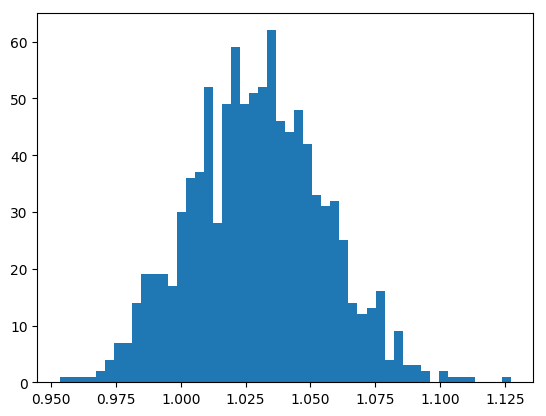

In [118]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = ExACLGD2.Permute(plot=False)
    T.append(bias)
T_obs = 1.09145796458
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [ ]:
A = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(probandLGD.TargetedExon)]["cds length"].values
B = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(probandLGD.UntargetedExon)]["cds length"].values
plt.hist(A, 100, normed=1, color = 'red', alpha = 0.5)
plt.hist(B, 100, normed=1, color = 'blue', alpha = 0.5)
plt.show()

In [77]:
gnomADlgd = set(gnomADLGD.TargetedExon)
prolgd = set(ProbandLGD.TargetedExon)
print gnomADlgd.intersection(prolgd), len(gnomADlgd.intersection(prolgd))

set([177795, 178006, 34566, 185607, 40587, 35982, 85141, 145688, 178074, 229275, 11552, 95393, 156962, 149925, 149926, 55719, 66473, 78000, 183603, 13108, 152246, 115772, 41150, 211016, 54477, 168790, 40535, 119896, 117593, 173658, 168795, 16220, 53213, 75103, 74592, 105020, 193774, 125168, 1265, 39026, 169336]) 41


[1.074127515854856, 1.0741811621722959, 1.074858208207526, 1.0749971320406115, 1.0750787688127723, 1.0757715273354447, 1.0808218096785214, 1.0830232468919423, 1.0850236647484186, 1.0858711630404858]
989
11
0.011


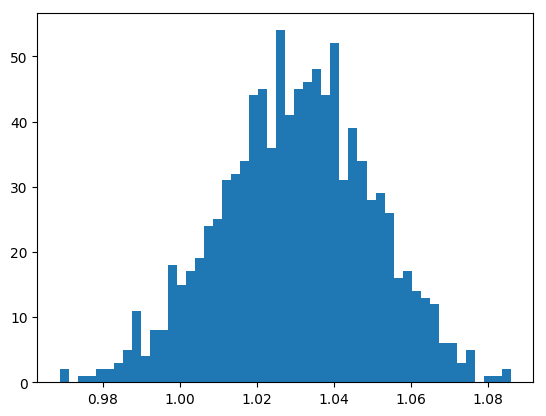

In [88]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = ExACLGD.Permute(plot=False)
    T.append(bias)
T_obs = 1.07195662765
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.0564713043222429, 1.0566538111917718, 1.0567703285091063, 1.0588699231050296, 1.0610410905713679, 1.0610702952408153, 1.0642955140840853, 1.0709243656985701, 1.0783073505168035, 1.0849340032733914]
997
3
0.003


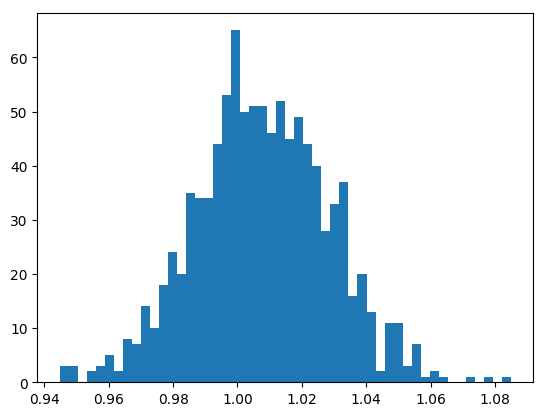

In [70]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = ProbandLGD.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.0643959257
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

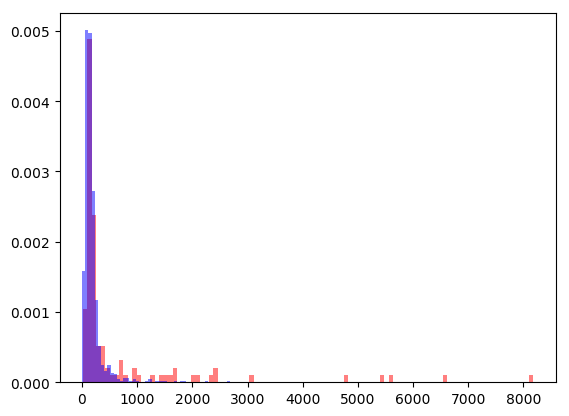

In [199]:
A = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(probandLGD.TargetedExon)]["cds length"].values
B = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(probandLGD.UntargetedExon)]["cds length"].values
plt.hist(A, 100, normed=1, color = 'red', alpha = 0.5)
plt.hist(B, 100, normed=1, color = 'blue', alpha = 0.5)
plt.show()

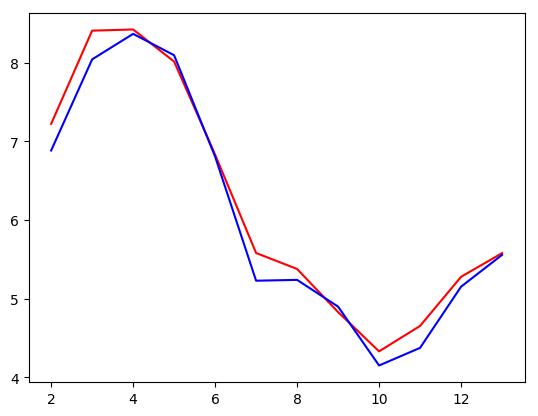

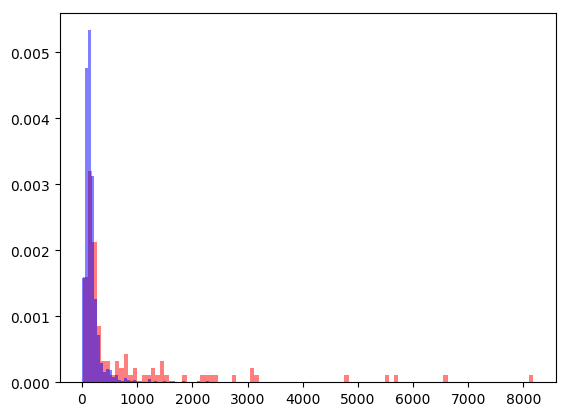

In [202]:
bias, TE, UE = probandLGD.Permute(plot=True)
A = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(TE)]["cds length"].values
B = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"].isin(UE)]["cds length"].values
#plt.hist(A, 100, normed=1, color = 'red', alpha = 0.5)
#plt.hist(B, 100, normed=1, color = 'blue', alpha = 0.5)
plt.show()

[1.0620799250062625, 1.0629802444048486, 1.0630689958710526, 1.0670636856983791, 1.0689751007384207, 1.0695910670742221, 1.0709249695793102, 1.0739381334418272, 1.0745954990527102, 1.0746560039253106]
993
7
0.007


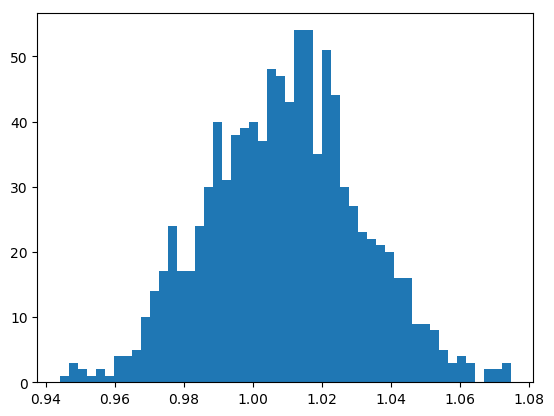

In [248]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = probandLGD.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.0643959257
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [233]:
cates = []
color=["red", "blue", "purple", "green"]
for i,func in enumerate(["Chromatin", "Channel&PSD", "Cytp&Sig", "TF&RBP"]):
    GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene.Func.str.contains(func)]
    #print GeneDF.head(2)
    Genes = list(set(GeneDF["gene_symbol"].values))
    tmp = GeneExonSet(expdict, func, color[i])
    for i, gene in enumerate(Genes):
        #print gene
        gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
        TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
        UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
        #print TargetedExon
        TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
        UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
        tmp.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
    cates.append(tmp)

Chromatin 1.59057767533 1.51437027105 0.0762074042819 1.05032283434
sibling lgd
avg.pre.tar: 9.95529684071; avg.post.tar: 6.78841551063; ratio.tar:1.46651259416
avg.pre.untar: 6.26592653362; avg.post.untar: 4.48186685871; ratio.untar:1.39806172989
rate.ratio:1.0489612603
Channel&PSD 1.59028305703 1.54538491839 0.0448981386398 1.02905304569
sibling lgd
avg.pre.tar: 10.356349971; avg.post.tar: 8.67057901126; ratio.tar:1.19442426596
avg.pre.untar: 6.49829815726; avg.post.untar: 5.60967225224; ratio.untar:1.15840959419
rate.ratio:1.03108975612
Cytp&Sig 1.11087844554 1.03246026043 0.0784181851099 1.07595273941
sibling lgd
avg.pre.tar: 11.5862267873; avg.post.tar: 9.28581765244; ratio.tar:1.24773361065
avg.pre.untar: 10.5124636034; avg.post.untar: 8.99145573609; ratio.untar:1.16916146973
rate.ratio:1.0672038405
TF&RBP 2.65030690076 2.14790666695 0.502400233814 1.23390226472
sibling lgd
avg.pre.tar: 16.8421575545; avg.post.tar: 8.93539305016; ratio.tar:1.88488155585
avg.pre.untar: 6.355422218

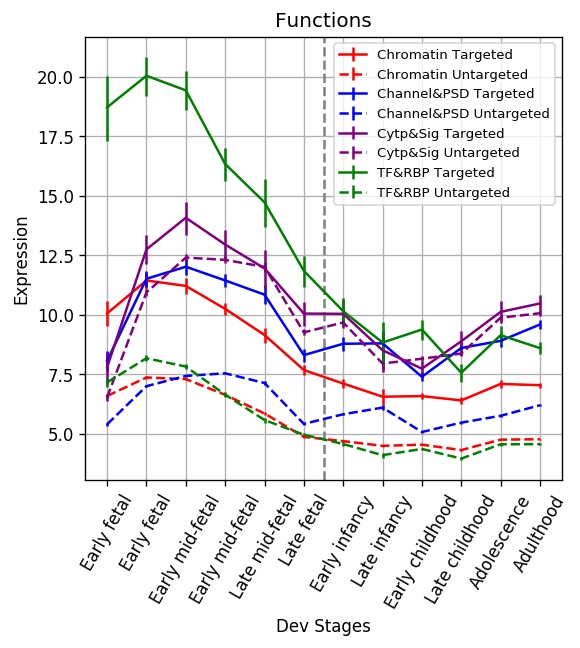

In [234]:
fig, ax = plt.subplots(dpi=120)
plt.title("Functions")
for cate in cates:
    Tseq, Terr, Useq, Uerr, All, AllErr = cate.Reduce()
    #print Tseq
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), All, yerr = AllErr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post,bias
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    print title
    print "avg.pre.tar: {}; avg.post.tar: {}; ratio.tar:{}".format(pre1, post1, T)
    print "avg.pre.untar: {}; avg.post.untar: {}; ratio.untar:{}".format(pre2, post2, U)
    print "rate.ratio:{}".format(T/U)
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle='--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

In [235]:
GeneDF1 = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene.Func.str.contains("Chromatin") | 
                                       bp_exon_row_meta_with_gene.Func.str.contains("TF&RBP")]
Genes1 = list(set(GeneDF1["gene_symbol"].values))
DEVEL = GeneExonSet(expdict, "DEVEL", "red")
for i, gene in enumerate(Genes1):
    gene_df = GeneDF1[GeneDF1["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    DEVEL.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)

GeneDF2 = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene.Func.str.contains("Channel&PSD") | 
                                       bp_exon_row_meta_with_gene.Func.str.contains("Cytp&Sig")]
Genes2 = list(set(GeneDF2["gene_symbol"].values))
NEURO = GeneExonSet(expdict, "NEURO", "blue")
for i, gene in enumerate(Genes2):
    gene_df = GeneDF2[GeneDF2["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    NEURO.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)   

55
DEVEL
avg.pre.tar: 10.744; avg.post.tar: 7.063; ratio.tar:1.521
avg.pre.untar: 6.277; avg.post.untar: 4.435; ratio.untar:1.415
rate.ratio:1.075
54
NEURO
avg.pre.tar: 10.680; avg.post.tar: 8.834; ratio.tar:1.209
avg.pre.untar: 7.327; avg.post.untar: 6.312; ratio.untar:1.161
rate.ratio:1.042


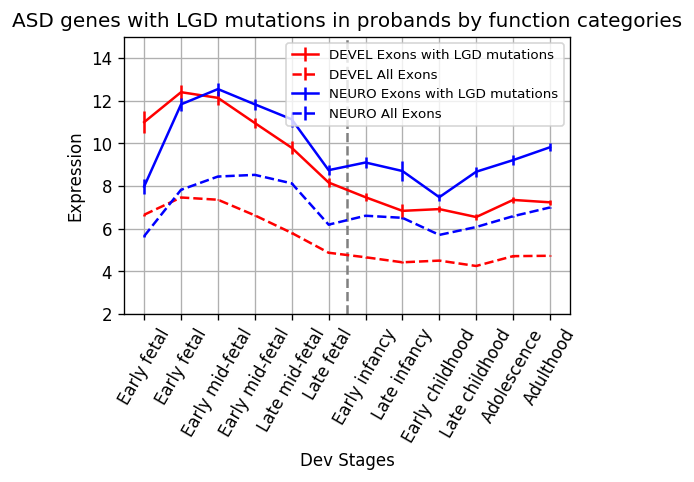

In [287]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands by function categories")
for cate in [DEVEL, NEURO]:
    print len(cate.TargetedExon)
    Tseq, Terr, Useq, Uerr, All, AllErr = cate.Reduce()
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Exons with LGD mutations", color=cate.GeneSetColor)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color='blue')
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=cate.GeneSetName +" All Exons", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    #print cate.GeneSetName, pre, post, pre-post, bias
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    print cate.GeneSetName
    print "avg.pre.tar: {:.3f}; avg.post.tar: {:.3f}; ratio.tar:{:.3f}".format(pre1, post1, T)
    print "avg.pre.untar: {:.3f}; avg.post.untar: {:.3f}; ratio.untar:{:.3f}".format(pre2, post2, U)
    print "rate.ratio:{:.3f}".format(T/U)
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
plt.ylim(2,15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()
#plt.savefig("./figures/function.pdf", bbox_inches = "tight")

[1.0347285684437231, 1.0370036524779638, 1.0387332000098402, 1.0401898065714281, 1.042057789310048, 1.0421664897914689, 1.0434095594260939, 1.0490239289191237, 1.0597275477114958, 1.0613566678159807]
1
0.001


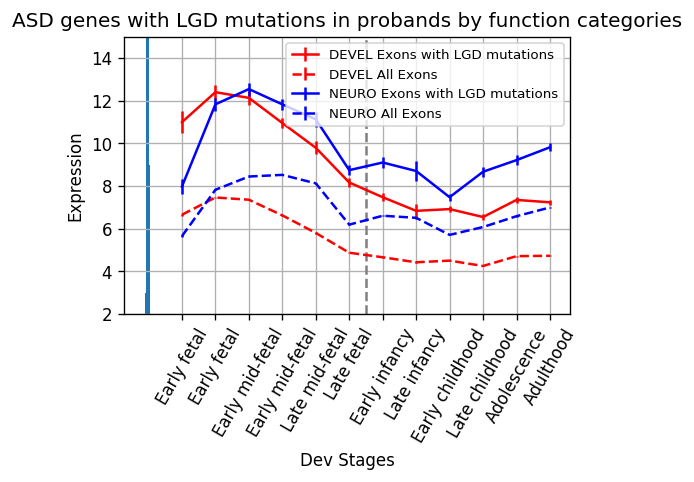

In [237]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = DEVEL.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.099
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.0522886271923406, 1.0551976609047384, 1.0558181877266288, 1.0565391210086981, 1.0565437372249189, 1.060461801698291, 1.0616248096366339, 1.0653583442579986, 1.0689262478753998, 1.074042937142236]
1
0.001


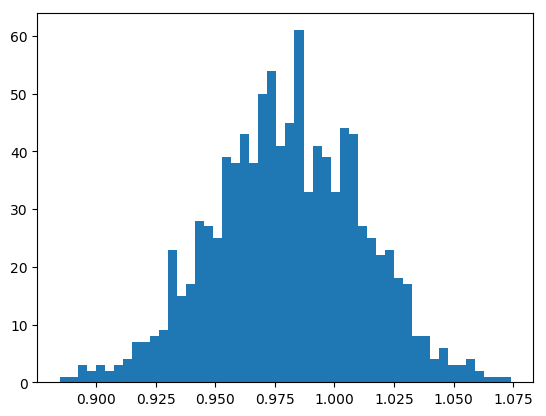

In [238]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = NEURO.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.076
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [239]:
# Female
FeMale_genes = list(bp_exon_row_meta_with_gene[
    bp_exon_row_meta_with_gene["Gender"].isin(["pF","pM;pF"])]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(FeMale_genes)]
Female = GeneExonSet(expdict, "Female", "blue")
for i, gene in enumerate(FeMale_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"]))]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"])) )]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"]))]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"])) )]["exon length"])
    Female.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# Male        
Male_genes = list(bp_exon_row_meta_with_gene[
    bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(Male_genes)]
Male = GeneExonSet(expdict, "Male", "red")
for i, gene in enumerate(Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) )]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                              (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) )]["exon length"])
    Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# HIQMale        
HIQ_Male_genes = set(bp_exon_row_meta_with_gene[
    (bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
    (bp_exon_row_meta_with_gene["NVIQ70"]>70)]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(HIQ_Male_genes)]
HIQ_Male = GeneExonSet(expdict, "H_NVIQ_Male", "green")
for i, gene in enumerate(HIQ_Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                    (gene_df["NVIQ70"]>70)]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
                                        (gene_df["NVIQ70"]>70))]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                          (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))  &
                                          (gene_df["NVIQ70"]>70)]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                               (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                               (gene_df["NVIQ70"]>70))]["exon length"])
    HIQ_Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# LIQMale        
LIQ_Male_genes = set(bp_exon_row_meta_with_gene[
    (bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
    (bp_exon_row_meta_with_gene["NVIQ70"]<=70)]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(LIQ_Male_genes)]
LIQ_Male = GeneExonSet(expdict, "L_NVIQ_Male", "purple")
for i, gene in enumerate(LIQ_Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                    (gene_df["NVIQ70"]<70)]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
                                        (gene_df["NVIQ70"]<70))]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                          (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                          (gene_df["NVIQ70"]<70)]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                               (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                               (gene_df["NVIQ70"]<70))]["exon length"])
    LIQ_Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)

[12.887842154134832, 15.930197553980168, 15.803700290969363, 13.352039707264074, 11.73116475819962, 9.2645941436317525, 8.6665890810279631, 8.1864754793339412, 7.6390083240356335, 8.2950362189245794, 8.916502824986777, 9.1521625495846965]
Female 1.70050183476 1.52603059858 0.174471236182 1.11433010344
Female
avg.pre.tar: 13.162; avg.post.tar: 8.476; ratio.tar:1.553
avg.pre.untar: 7.714; avg.post.untar: 5.553; ratio.untar:1.389
rate.ratio:1.118
[7.7567532883708745, 9.6941530878998545, 10.036683888796468, 9.7635620611502834, 8.9675851239925546, 7.5786372944490514, 7.5663379988798365, 7.0053476949232394, 6.6503603595543863, 6.4788063335538562, 7.2676702655133978, 7.3232125783678228]
H_NVIQ_Male 1.32410329612 1.33837697762 -0.0142736815009 0.989335081416
H_NVIQ_Male
avg.pre.tar: 8.966; avg.post.tar: 7.049; ratio.tar:1.272
avg.pre.untar: 6.796; avg.post.untar: 5.267; ratio.untar:1.290
rate.ratio:0.986
[8.2227689173403817, 11.586513981190262, 11.888823120658484, 11.028127554428153, 10.394435

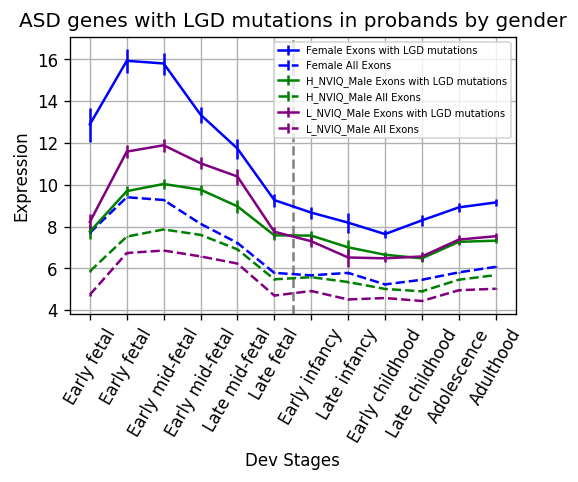

In [240]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands by gender")
for cate in [Female, HIQ_Male, LIQ_Male]:
    Tseq, Terr, Useq, Uerr, All, AllErr = cate.Reduce()
    print Tseq
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Exons with LGD mutations", color=cate.GeneSetColor)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color='blue')
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=cate.GeneSetName +" All Exons", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post, bias
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    print cate.GeneSetName
    print "avg.pre.tar: {:.3f}; avg.post.tar: {:.3f}; ratio.tar:{:.3f}".format(pre1, post1, T)
    print "avg.pre.untar: {:.3f}; avg.post.untar: {:.3f}; ratio.untar:{:.3f}".format(pre2, post2, U)
    print "rate.ratio:{:.3f}".format(T/U)
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=6)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()
#plt.savefig("./figures/gender.pdf", bbox_inches = "tight")

In [192]:
# Female
FeMale_genes = list(bp_exon_row_meta_with_gene[
    bp_exon_row_meta_with_gene["Gender"].isin(["pF","pM;pF"])]["gene_symbol"])

Male_genes = list(bp_exon_row_meta_with_gene[
    bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])]["gene_symbol"])
Both_genes = set(FeMale_genes).intersection(set(Male_genes))
print Both_genes
#genes = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(Both_genes)]

set([u'CHD2', u'ADNP', u'CHD8', u'TBR1', u'KATNAL2', u'GRIN2B', u'SCN2A', u'DYRK1A', u'NCKAP1', u'ANKRD11'])


In [256]:
Dir = "/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/"
Predicted = set([x.strip() for x in file(Dir+"../ASD_high_confidence_genes_post80.txt")])
LGD = set(["noStart", "frame-shift", "nonsense", "noEnd", "no-frame-shift-newStop","splice-site"])
InPro = set(["pMsM", "pMsF", "pFsF", "pF", "pM", "pFsM"])
phenotype = pd.read_excel(Dir+"Supplementary_Table_1.xlsx")
variants = pd.read_excel(Dir+"Supplementary_Table_2.xlsx")
ProLGD = variants[(variants["inChild"].isin(InPro)) & (variants["effectType"].isin(LGD))]
Female = ProLGD[(ProLGD["inChild"] == "pF") & (ProLGD["effectGene"].isin(Both_genes))]
Male = ProLGD[(ProLGD["inChild"] == "pM") & (ProLGD["effectGene"].isin(Both_genes))]
FemaleP = ProLGD[(ProLGD["inChild"] == "pF") & (ProLGD["effectGene"].isin(Predicted))]
MaleP = ProLGD[(ProLGD["inChild"] == "pM") & (ProLGD["effectGene"].isin(Predicted))]
FemaleALL = ProLGD[(ProLGD["inChild"] == "pF")]
MaleALL = ProLGD[(ProLGD["inChild"] == "pM")]

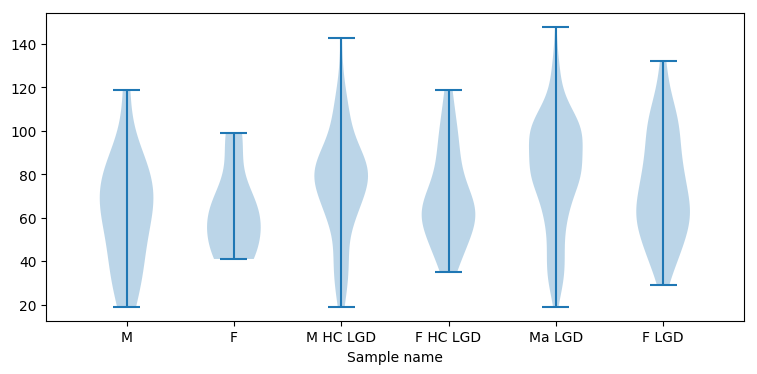

18 11
MannwhitneyuResult(statistic=102.5, pvalue=0.89264637480164066)
MannwhitneyuResult(statistic=1122.5, pvalue=0.04491627147678616)
MannwhitneyuResult(statistic=218.0, pvalue=0.32844289834822249)
Ks_2sampResult(statistic=0.30397727272727276, pvalue=0.01641605983029535)


In [278]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
fig, ax1 = plt.subplots(figsize=(9, 4))
FemaleIQ = phenotype[phenotype["familyId"].isin(Female["familyId"].values)]['probandNVIQ']
MaleIQ = phenotype[phenotype["familyId"].isin(Male["familyId"].values)]['probandNVIQ']
FemaleIQP = phenotype[phenotype["familyId"].isin(FemaleP["familyId"].values)]['probandNVIQ']
MaleIQP = phenotype[phenotype["familyId"].isin(MaleP["familyId"].values)]['probandNVIQ']
FemaleIQALL = phenotype[phenotype["familyId"].isin(FemaleALL["familyId"].values)]['probandNVIQ']
FemaleIQALL = FemaleIQALL[~np.isnan(FemaleIQALL)]
MaleIQALL = phenotype[phenotype["familyId"].isin(MaleALL["familyId"].values)]['probandNVIQ']
plt.violinplot([MaleIQ, FemaleIQ, MaleIQP, FemaleIQP, MaleIQALL, FemaleIQALL], positions=[1, 2, 3, 4, 5, 6])
set_axis_style(ax1, ["M", "F", "M HC LGD", "F HC LGD", "Ma LGD", "F LGD"])
#plt.grid(True)
plt.show()
print len(MaleIQ), len(FemaleIQ)
print scipy.stats.mannwhitneyu(MaleIQ, FemaleIQ, alternative="two-sided")
#print scipy.stats.ks_2samp(MaleIQ, MaleIQP)
print scipy.stats.mannwhitneyu(MaleIQP, MaleIQ, alternative="two-sided")
print scipy.stats.mannwhitneyu(FemaleIQP, FemaleIQ, alternative="two-sided")
print scipy.stats.ks_2samp(MaleIQP, FemaleIQP)

In [ ]:
genes = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(Both_genes)]
fe_exons = genes[genes["Gender"].isin(["pF","pM;pF"])]
ma_exons = genes[genes["Gender"].isin(["pM", "pM;pM","pM;pF"])]
others = genes[~genes["Gender"].isin(["pF","pM;pF","pM", "pM;pM","pM;pF"])]
#display(fe_exons)
def Reduce(expdict, exons):
    Tseq, Terr= [], []
    for stage in Stages:
        tmp = []
        for gene, ExonID in zip(exons["gene_symbol"].values, exons["row_num"].values):
            tmp.extend(expdict[gene][ExonID][stage])
        Tseq.append(np.mean(tmp))
        Terr.append( math.sqrt( np.var(tmp) / len(tmp) ) )
    Terr = converterror(Tseq, Terr)
    Tseq = [2 ** x for x in Tseq]
    #Terr = converterror(Tseq, Terr)
    return Tseq, Terr
def converterror(means, stderr):
    upper, lower = [], []
    for mean, error in zip(means, stderr):
        upper.append( (2**(mean+error)) - (2**(mean)) )
        lower.append( (2**(mean)) - (2**(mean-error)) )
        #print mean, error, 2**(mean), (2**(mean+error)) - (2**(mean)) , (2**(mean)) - (2**(mean-error))
    return (upper, lower)

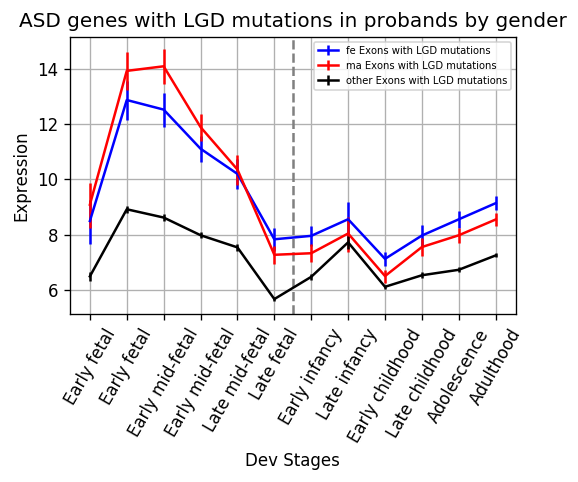

In [188]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands by gender")
for GeneSetName, GeneSetColor, cate in zip(['fe', "ma", "other"], ["blue", "red", "black"], [fe_exons, ma_exons, others]):
    Tseq, Terr = Reduce(expdict,cate)
    #print Tseq
    #print Terr
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=GeneSetName+" Exons with LGD mutations", color=GeneSetColor)
    #ax.plot(range(2,14), Tseq, label=GeneSetName+" Exons with LGD mutations", color=GeneSetColor)
    ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=6)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()
#plt.savefig("./figures/gender.pdf", bbox_inches = "tight")

In [241]:
predicted = set([x.strip() for x in file("/Users/jiayao/Work/BrainDisorders/data/ASD_high_confidence_genes_post80.txt")])

In [242]:
bp_exon_row_meta_mis_with_gene = pd.read_excel("GenesExonsTargetedByMIS.xlsx", index=False)
bp_exon_row_meta_mis_with_gene = bp_exon_row_meta_mis_with_gene.replace(np.nan, '', regex=True)
bp_exon_row_meta_mis_with_gene = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"].isin(predicted)]
bp_exon_row_meta_mis_with_var = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["Vars"]!=""]
bp_exon_row_meta_mis_without_var = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["Vars"]==""]
print bp_exon_row_meta_mis_with_gene.shape, bp_exon_row_meta_mis_with_var.shape, bp_exon_row_meta_mis_without_var.shape

(3311, 16) (141, 16) (3170, 16)


In [252]:
mis_expdict = ins.LoadGeneSetDataFromFil("qn.ProbandMIS.Regionsgt20.GeneExonLog2Exp.csv")
proband_mis_Genes = list(set(bp_exon_row_meta_mis_with_gene["gene_symbol"].values))
probandMIS = GeneExonSet(mis_expdict)
for i, gene in enumerate(proband_mis_Genes):
    gene_df = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandMIS.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

proband LGD 1.51910435026 1.42761930068 1.06408224485
proband Mis 1.54423536139 1.47170594304 1.04928254771


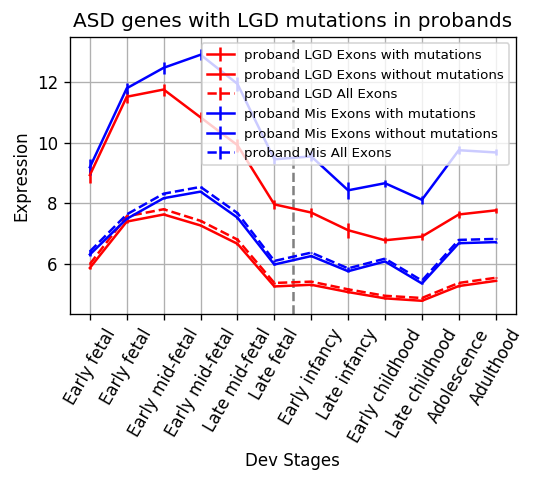

In [253]:
prolgd = probandLGD.Reduce(logscale=False)
promis = probandMIS.Reduce(logscale=False)
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands")
for title, color, Dat in [("proband LGD", 'red', prolgd),("proband Mis", 'blue', promis)]:
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat

    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title +" Exons with mutations", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, label=title+" Exons without mutations", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=title + " All Exons", color=color)
    pre, post, bias = Bias(Tseq, Useq)
    print title, pre, post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.ylim(3.75,14.25)
plt.show()

[1.0174031637041758, 1.0198416052833563, 1.0209770270598257, 1.0230152481384658, 1.0235207881950465, 1.0245555263099684, 1.0292502726664288, 1.0309679081903826, 1.0362931747243616, 1.0508577629465625]
999
1
0.001


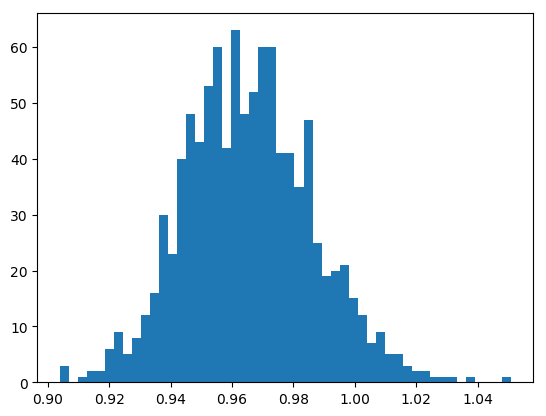

In [256]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = probandMIS.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.04928254771
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [254]:
# Female
FeMale_genes = list(bp_exon_row_meta_mis_with_gene[
    bp_exon_row_meta_mis_with_gene["Gender"].isin(["pF","pM;pF"])]["gene_symbol"])
GeneDF = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"].isin(FeMale_genes)]
Female = GeneExonSet(mis_expdict, "Female", "blue")
for i, gene in enumerate(FeMale_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"]))]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"])) )]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"]))]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"])) )]["exon length"])
    Female.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# Male        
Male_genes = list(bp_exon_row_meta_mis_with_gene[
    bp_exon_row_meta_mis_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])]["gene_symbol"])
GeneDF = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"].isin(Male_genes)]
Male = GeneExonSet(mis_expdict, "Male", "red")
for i, gene in enumerate(Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) )]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                              (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) )]["exon length"])
    Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# HIQMale        
HIQ_Male_genes = set(bp_exon_row_meta_mis_with_gene[
    (bp_exon_row_meta_mis_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
    (bp_exon_row_meta_mis_with_gene["NVIQ70"]>70)]["gene_symbol"])
GeneDF = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"].isin(HIQ_Male_genes)]
HIQ_Male = GeneExonSet(mis_expdict, "H_NVIQ_Male", "green")
for i, gene in enumerate(HIQ_Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                    (gene_df["NVIQ70"]>70)]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
                                        (gene_df["NVIQ70"]>70))]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                          (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))  &
                                          (gene_df["NVIQ70"]>70)]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                               (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                               (gene_df["NVIQ70"]>70))]["exon length"])
    HIQ_Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# LIQMale        
LIQ_Male_genes = set(bp_exon_row_meta_mis_with_gene[
    (bp_exon_row_meta_mis_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
    (bp_exon_row_meta_mis_with_gene["NVIQ70"]<=70)]["gene_symbol"])
GeneDF = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"].isin(LIQ_Male_genes)]
LIQ_Male = GeneExonSet(mis_expdict, "L_NVIQ_Male", "purple")
for i, gene in enumerate(LIQ_Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                    (gene_df["NVIQ70"]<70)]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
                                        (gene_df["NVIQ70"]<70))]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                          (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                          (gene_df["NVIQ70"]<70)]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                               (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                               (gene_df["NVIQ70"]<70))]["exon length"])
    LIQ_Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)

[11.888871453716012, 14.784184599171686, 15.407009668331622, 16.114336457479077, 13.256714037229637, 11.428046302423667, 11.009108149527291, 8.4769334738275965, 9.3234048374266383, 8.2873269571443888, 11.133770783298534, 10.769292008627804]
Female 1.42568412455 1.40844279447 0.0172413300752 1.0122414131
Female
avg.pre.tar: 13.813; avg.post.tar: 9.833; ratio.tar:1.405
avg.pre.untar: 9.727; avg.post.untar: 6.962; ratio.untar:1.397
rate.ratio:1.005
[9.0476371861951197, 11.506257686266215, 12.386270214105634, 12.662971190257347, 11.773590474698853, 9.1451800131194947, 9.1782217456285036, 7.9355715288062267, 8.7466105594355952, 7.6932504562982444, 9.482650498490429, 9.1719184430572724]
H_NVIQ_Male 1.58858915519 1.47810762406 0.110481531132 1.0747452549
H_NVIQ_Male
avg.pre.tar: 11.087; avg.post.tar: 8.701; ratio.tar:1.274
avg.pre.untar: 6.978; avg.post.untar: 5.892; ratio.untar:1.184
rate.ratio:1.076
[8.8259132494803882, 11.604366358438307, 11.80077311467247, 12.68006510823666, 12.5683498578

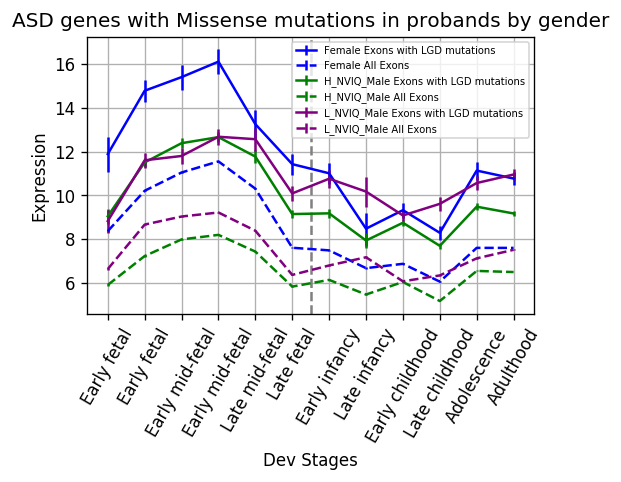

In [255]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with Missense mutations in probands by gender")
for cate in [Female, HIQ_Male, LIQ_Male]:
    Tseq, Terr, Useq, Uerr, All, AllErr = cate.Reduce()
    print Tseq
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Exons with LGD mutations", color=cate.GeneSetColor)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color='blue')
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=cate.GeneSetName +" All Exons", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post, bias
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    print cate.GeneSetName
    print "avg.pre.tar: {:.3f}; avg.post.tar: {:.3f}; ratio.tar:{:.3f}".format(pre1, post1, T)
    print "avg.pre.untar: {:.3f}; avg.post.untar: {:.3f}; ratio.untar:{:.3f}".format(pre2, post2, U)
    print "rate.ratio:{:.3f}".format(T/U)
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=6)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()
#plt.savefig("./figures/gender.pdf", bbox_inches = "tight")

[1.0939700603851634, 1.0950876320501022, 1.0957106090901139, 1.102075706020174, 1.1061693506591352, 1.1071019600094845, 1.1083320072850813, 1.1100789617202609, 1.1132647014552444, 1.1403577378742755]
1
0.001


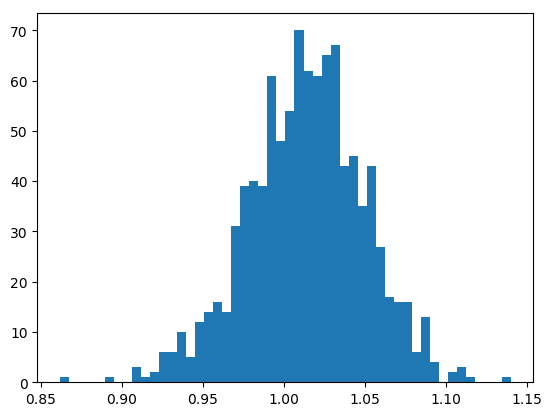

In [187]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = Female.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.147
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[0.99976309603867597, 1.0010080919108297, 1.0022724716695852, 1.0027265286855958, 1.0043088498098367, 1.0045143825194476, 1.00528144328263, 1.0092518962146668, 1.0117414911693958, 1.027944176196665]
997
3
0.003


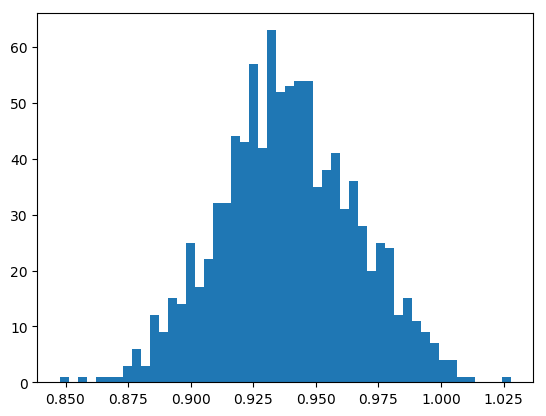

In [188]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = HIQ_Male.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.008
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.1484773678686486, 1.1506032527142498, 1.1544744923208325, 1.1551197705809675, 1.1553744666575567, 1.1618986192641327, 1.1632231834071292, 1.1687426833512509, 1.1733687097251673, 1.1771686120002931]
1
0.001


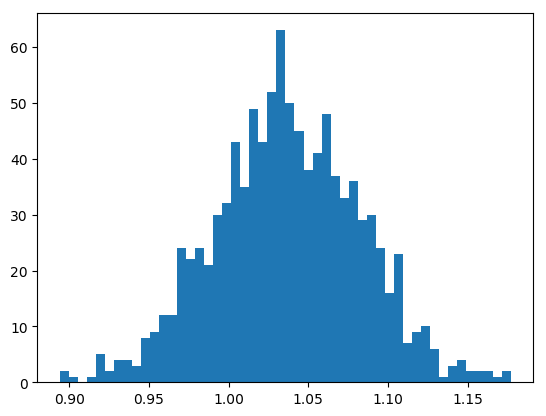

In [189]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = LIQ_Male.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.201
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [177]:
SynVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProSYN.xlsx"
syn_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SynVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_syn_with_gene = syn_annotated_exon_row_meta[syn_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_syn_with_gene.to_excel("GenesExonsTargetedBySYN.xlsx", index=False)
bp_exon_row_meta_syn_with_var = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["Vars"]!=""]
bp_exon_row_meta_syn_without_var = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["Vars"]==""]
print bp_exon_row_meta_syn_with_gene.shape, bp_exon_row_meta_syn_with_var.shape, bp_exon_row_meta_syn_without_var.shape

309222(12454, 16) (615, 16) (11839, 16)


In [178]:
SibNSYNVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014SibSYN.xlsx"
sibnsyn_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SibNSYNVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_sibnsyn_with_gene = sibnsyn_annotated_exon_row_meta[sibnsyn_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_sibnsyn_with_gene.to_excel("GenesExonsTargetedBySibSYN.xlsx", index=False)
bp_exon_row_meta_sibnsyn_with_var = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["Vars"]!=""]
bp_exon_row_meta_sibnsyn_without_var = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["Vars"]==""]
print bp_exon_row_meta_sibnsyn_with_gene.shape, bp_exon_row_meta_sibnsyn_with_var.shape, bp_exon_row_meta_sibnsyn_without_var.shape

309222(8737, 16) (465, 16) (8272, 16)


In [174]:
SibLGDVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014SibLGD.xlsx"
siblgd_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SibLGDVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_siblgd_with_gene = siblgd_annotated_exon_row_meta[siblgd_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_siblgd_with_gene.to_excel("GenesExonsTargetedBySibLGD.xlsx", index=False)
bp_exon_row_meta_siblgd_with_var = bp_exon_row_meta_siblgd_with_gene[bp_exon_row_meta_siblgd_with_gene["Vars"]!=""]
bp_exon_row_meta_siblgd_without_var = bp_exon_row_meta_siblgd_with_gene[bp_exon_row_meta_siblgd_with_gene["Vars"]==""]
print bp_exon_row_meta_siblgd_with_gene.shape, bp_exon_row_meta_siblgd_with_var.shape, bp_exon_row_meta_siblgd_without_var.shape

309222(3769, 16) (178, 16) (3591, 16)


In [32]:
syn_expdict = ins.LoadGeneSetDataFromFil("../data/qn.ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
proband_syn_Genes = list(set(bp_exon_row_meta_syn_with_gene["gene_symbol"].values))
probandSYN = GeneExonSet(syn_expdict)
for i, gene in enumerate(proband_syn_Genes):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    probandSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
    
sibsyn_expdict = ins.LoadGeneSetDataFromFil("../data/qn.SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"].values))
SiblingSYN = GeneExonSet(sibsyn_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SiblingSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
    
siblgd_expdict = ins.LoadGeneSetDataFromFil("../data/qn.SiblingLGD.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_siblgd_with_gene["gene_symbol"].values))
SiblingLGD = GeneExonSet(siblgd_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_siblgd_with_gene[bp_exon_row_meta_siblgd_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SiblingLGD.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

IOError: [Errno 2] No such file or directory: '../data/qn.ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv'

In [268]:
MisVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProMIS.xlsx"
mis_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, MisVarFile, IntersectionWithPredicted=False)
mis_annotated_exon_row_meta = mis_annotated_exon_row_meta[mis_annotated_exon_row_meta["GeneHited"]=="T"]

309222

In [278]:

print mis_annotated_exon_row_meta.shape, mis_annotated_exon_row_meta.shape, mis_annotated_exon_row_meta.shape
mis_expdict = ins.LoadGeneSetDataFromFil("qn.ProbandMIS.Regionsgt20.GeneExonLog2Exp.csv")
proband_mis_Genes = list(set(mis_annotated_exon_row_meta["gene_symbol"].values))
probandMIS = GeneExonSet(mis_expdict)
for i, gene in enumerate(proband_mis_Genes):
    gene_df = mis_annotated_exon_row_meta[mis_annotated_exon_row_meta["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    probandMIS.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
print i

(30127, 16) (30127, 16) (30127, 16)
1435


In [279]:
print len(probandMIS.TargetedExon)

1583


['proband', 'syn']
proband syn 1.30596550687 1.32755237238 0.98373934923
proband syn
avg.pre.tar: 4.015; avg.post.tar: 3.941; ratio.tar:1.019
avg.pre.untar: 3.076; avg.post.untar: 2.970; ratio.untar:1.036
rate.ratio:0.984
['proband', 'mis']
proband mis 1.30881716975 1.31282386886 0.996948029968
proband mis
avg.pre.tar: 4.525; avg.post.tar: 4.355; ratio.tar:1.039
avg.pre.untar: 3.460; avg.post.untar: 3.319; ratio.untar:1.042
rate.ratio:0.997
['sibling', 'syn']
sibling syn 1.21143137965 1.20657640499 1.00402376065
sibling syn
avg.pre.tar: 3.750; avg.post.tar: 3.650; ratio.tar:1.027
avg.pre.untar: 3.097; avg.post.untar: 3.027; ratio.untar:1.023
rate.ratio:1.004
['sibling', 'lgd']
sibling lgd 1.43404593392 1.48498833138 0.965695085685
sibling lgd
avg.pre.tar: 4.482; avg.post.tar: 4.582; ratio.tar:0.978
avg.pre.untar: 3.127; avg.post.untar: 3.087; ratio.untar:1.013
rate.ratio:0.966


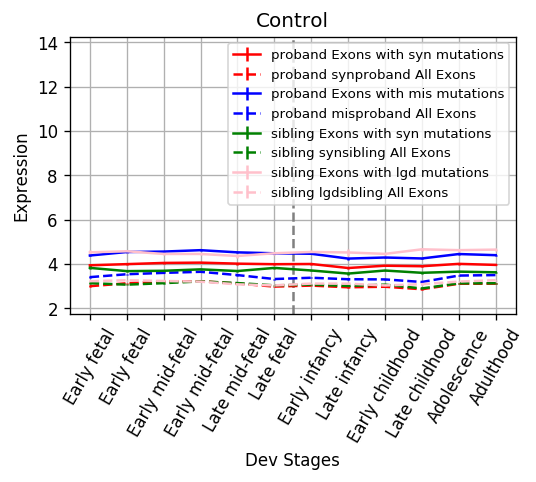

In [276]:
prosynDat = probandSYN.Reduce()
promisDat = probandMIS.Reduce()
sibsynDat = SiblingSYN.Reduce()
siblgdDat = SiblingLGD.Reduce()
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat), ("proband mis", 'blue', promisDat),
                          ("sibling syn", 'green', sibsynDat), ("sibling lgd", 'pink', siblgdDat)]:
    Tseq, Terr, Useq, Uerr, All, AllErr = Dat
    print title.split()
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label="{} Exons with {} mutations".format(title.split()[0],title.split()[1]), color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color='blue')
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=title +"{} All Exons".format(title.split()[0]), color=color)
    pre, post, bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, bias
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    print title
    print "avg.pre.tar: {:.3f}; avg.post.tar: {:.3f}; ratio.tar:{:.3f}".format(pre1, post1, T)
    print "avg.pre.untar: {:.3f}; avg.post.untar: {:.3f}; ratio.untar:{:.3f}".format(pre2, post2, U)
    print "rate.ratio:{:.3f}".format(T/U)
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
plt.ylim(1.75,14.25)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.tight_layout()
plt.show()
#plt.gcf().subplots_adjust(bottom=0.5)
#plt.savefig("./figures/Control.pdf", bbox_inches = "tight")

In [30]:
siblgdDat = SiblingLGD.Reduce()
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("Control")
for title, color, Dat in [("sibling lgd", 'pink', siblgdDat)]:
    Tseq, Terr, Useq, Uerr, All, AllErr = Dat
    print title.split()
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label="{} Exons with {} mutations".format(title.split()[0],title.split()[1]), color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color='blue')
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=title +"{} All Exons".format(title.split()[0]), color=color)
    pre, post, bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, bias
    pre1 = np.mean(Tseq[0:6])
    post1 = np.mean(Tseq[6:13])
    T = pre1/post1
    pre2 = np.mean(Useq[0:6])
    post2 = np.mean(Useq[6:13])
    U = pre2/post2
    print title
    print "avg.pre.tar: {:.3f}; avg.post.tar: {:.3f}; ratio.tar:{:.3f}".format(pre1, post1, T)
    print "avg.pre.untar: {:.3f}; avg.post.untar: {:.3f}; ratio.untar:{:.3f}".format(pre2, post2, U)
    print "rate.ratio:{:.3f}".format(T/U)
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
plt.ylim(1.75,14.25)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.tight_layout()
plt.show()
#plt.gcf().subplots_adjust(bottom=0.5)

NameError: name 'SiblingLGD' is not defined

[1.0108937534933693, 1.0115199462936564, 1.0118659684847164, 1.0125932991696294, 1.0139165468486468, 1.0159107744794567, 1.016884356590092, 1.0172456133138741, 1.0174183913850239, 1.0230528249162389]
168
832
0.832


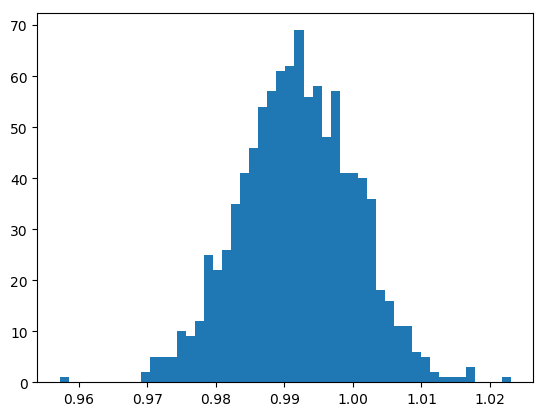

In [249]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = probandSYN.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 0.984
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.010302522210466, 1.0104875975321499, 1.0106179675275702, 1.0107357370274148, 1.0117317885534047, 1.011928366162115, 1.0124198282393693, 1.0125566630531164, 1.0126635261805552, 1.0135052693891684]
501
499
0.499


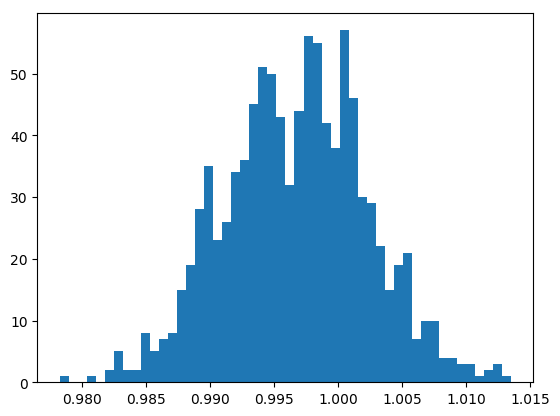

In [286]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = probandMIS.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 0.997
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.0170724926962726, 1.017167784614778, 1.017329165861182, 1.0174406345869813, 1.0194589508061596, 1.0199353586759661, 1.0205097922557556, 1.0205362725023048, 1.025646766704889, 1.0292257330823267]
790
210
0.21


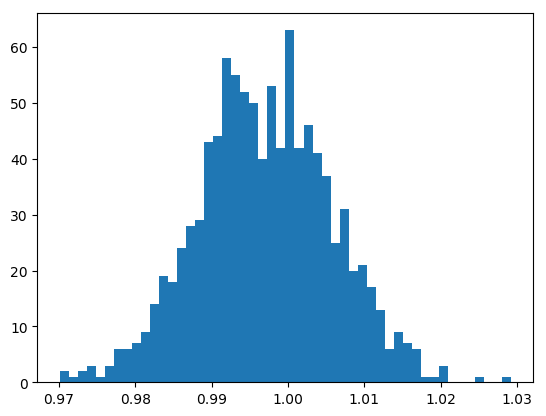

In [250]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = SiblingSYN.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 1.004
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[1.0263401711315636, 1.0276738083750312, 1.0292131369713746, 1.0293290303163625, 1.0293382660239532, 1.0295613549430824, 1.0303754363740736, 1.0306154486499608, 1.0315927586858227, 1.032330143914802]
101
899
0.899


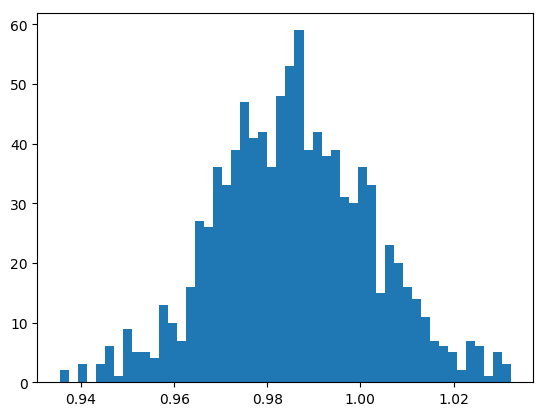

In [251]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = SiblingLGD.Permute(plot=False)
    T.append(bias)
#T_obs = O_bias
T_obs = 0.966
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()